In [9]:
# Load our stuff
import pkgutil
from pathlib import Path
import numpy as np
from Bio import SeqIO
from keras import optimizers, Input, Model
from keras.models import Sequential
import keras.backend as K
import matplotlib.pyplot as plt
from keras.layers import (
    Dense,
    TimeDistributed,
    SimpleRNN,
    Dropout,
    Conv2D,
    Conv2DTranspose,
    Flatten,
    Conv1D,
    MaxPooling2D,
    Reshape,
    UpSampling2D,
)
import scipy
import math
import csv
import random
##### USER INPUTS (Edit some of these to be CLI eventually)

# Context model length and pos_mutating
context_model_length = 3
context_model_pos_mutating = 2
# Path to aid model
aid_context_model = "data/aid_logistic_3mer.csv"
# Num seqs and n_mutation rounds
n_seqs = 1
n_mutation_rounds = 1


In [10]:
subset = []
with open('subset.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        subset.append(row)


In [11]:
germline = 'ATGAGCGAAAAATACATCGTCACCTGGGACATGTTGCAGATCCATGCACGTAAACTCGCAAGCCGACTGATGCCTTCTGAACAATGGAAAGGCATTATTGCCGTAAGCCGTGGCGGTCTGGTACCGGGTGCGTTACTGGCGCGTGAACTGGGTATTCGTCATGTCGATACCGTTTGTATTTCCAGCTACGATCACGACAACCAGCGCGAGCTTAAAGTGCTGAAACGCGCAGAAGGCGATGGCGAAGGCTTCATCGTTATTGATGACCTGGTGGATACCGGTGGTACTGCGGTTGCGATTCGTGAAAT'
germline = [k for k in germline]

In [12]:
n = np.size(germline)
c_array = np.zeros(n)
for i in range(n):
    c_array[i] = 1.0 * (germline[i] == 'C')

In [13]:
subset = subset[1:309]
seqs = []
for i in range(2242):
    seqs.append([k[i+1] for k in subset])
    
seqs = np.array(seqs)
marg_probs = (1.0-np.mean(seqs == germline, axis = 0))
marg_probs = np.sqrt(5)*((marg_probs-np.mean(marg_probs))/np.sqrt(np.var(marg_probs)))

In [14]:
def sample_prior(sitespec = False):
    ls = np.random.uniform(low = -12.0, high = -2.0)
    sg = np.random.uniform(low = 5.0, high = 15.0)
    br = np.random.uniform(low = 0.05, high = 0.25)
    if sitespec:
        off = marg_probs -10.0
    else:
        off = -10
    return { "base_rate" : br,
                       "lengthscale" : np.exp(ls),
                       "gp_sigma" : sg,
                       "gp_ridge" : .01,
            "gp_offset": off
            }

In [15]:
def make_se_kernel(x, lengthscale, sigma, gp_ridge):
    D = np.zeros([len(x), len(x)])
    upper_tri = np.triu_indices(len(x), 1)
    D[upper_tri] = ((np.array(x)[upper_tri[0]] - np.array(x)[upper_tri[1]])**2)
    D += D.T
    K = sigma**2 * np.exp(-D / (2 * lengthscale))
    np.fill_diagonal(K, K.diagonal() + gp_ridge)
    return K

def forward_sample_sequence_sgcp(sequence, params, re):
    n = np.size(sequence)
    if re:
        random = np.random.normal(loc = 1.0, scale = 1.0)
    else:
        random = 0.0
    vals = np.random.poisson(lam = np.exp(np.log(params['base_rate'])+random), size = n)
    # Only include prelesions at c site
    vals = np.multiply(vals, c_array)
    x = []
    means = []
    for i in range(np.size(vals)):
        if vals[i] > 0:
            conts = (i-np.random.uniform(size = 1))/n
            x = np.append(x, conts)
            if(len(params['gp_offset'])> 1):
                means = np.append(means, params['gp_offset'][i])
            else:
                means = np.append(means, -10.0)
    N = np.size(x)
    if N > 0:
        K = make_se_kernel(x, params['lengthscale'], params['gp_sigma'], params['gp_ridge'])
        lambda_of_x = np.random.multivariate_normal(mean = np.zeros(N)+means, cov = K)
        sigma_lambda_of_x = 1 / (1 + np.exp(lambda_of_x))
        uniforms = np.random.uniform(low = 0, high = 1, size = len(x))
        A_and_g = [(xi, li) for (xi, si, li, u) in zip(x, sigma_lambda_of_x, lambda_of_x, uniforms) if 0 < li]
        A_tilde_and_g = [(xi, li) for (xi, si, li, u) in zip(x, sigma_lambda_of_x, lambda_of_x, uniforms) if 0 >= li]
        A = [a for (a, g) in A_and_g]
        A_tilde = [at for (at, g) in A_tilde_and_g]
        g = [g for (a, g) in A_and_g + A_tilde_and_g]
    else:
        A = []
        A_tilde = []
        g = []
    return({ "A" : A, "A_tilde" : A_tilde, "g" : g})

def sample_seq(sequence, params, re):
    new_seq = sequence[:]
    res = forward_sample_sequence_sgcp(sequence,params, re)
    A = np.unique(np.ceil(np.multiply(res['A'],len(sequence))))
    muts = np.random.choice(a = ['A','G','T'], size = len(A))
    for i in range(len(A)):
        new_seq[int(A[i])] = muts[i]
    A_tilde = np.unique(np.ceil(np.multiply(res['A_tilde'],len(sequence))))
    g = res['g']
    return({"seq": new_seq,  "A" : A, "A_tilde" : A_tilde, "g" : g})
def process_latent(seq_res):
    n = len(seq_res['seq'])
    A = seq_res['A']
    A_tilde = seq_res['A_tilde']
    g = seq_res['g']
    A_long = np.zeros(n)
    A_tilde_long = np.zeros(n)
    g_long = np.zeros(n)
    k = 0
    for i in A:
        A_long[int(i)] = A_long[int(i)]+1
        g_long[int(i)] = g[k]
        k = k+1
    for i in A_tilde:
        A_tilde_long[int(i)] = A_tilde_long[int(i)]+1
        g_long[int(i)] = g[k]
        k = k+1
    return(np.stack([g_long,A_long, A_tilde_long],axis = 1))
def weight_array(ar, weights):
     sort = weights[np.argsort(ar)].cumsum()/np.sum(weights)
     sort_ar = np.sort(ar)
     return sort_ar,sort
    
# Get a 2d hot encoding of a sequence
def hot_encode_2d(seq):
    seq_hot = np.zeros((len(seq), 4, 1))
    for j in range(len(seq)):
        seq_hot[j, 0, 0] = seq[j] == "A"
        seq_hot[j, 1, 0] = seq[j] == "T"
        seq_hot[j, 2, 0] = seq[j] == "G"
        seq_hot[j, 3, 0] = seq[j] == "C"
    return seq_hot

def gen_batch(seq, params, batch_size, re):
    mut = []
    les = []
    preles = []
    gaus = []
    for i in range(batch_size):
        temp = sample_seq(seq, params, re)
        mut.append(temp['seq'])
        les.append(temp['A'])
        preles.append(temp['A_tilde'])
        gaus.append(temp['g'])
    return np.array(mut), np.array(les), np.array(preles), np.array(gaus)

In [16]:
def get_colocal(batch_size, model_params, sample = None, re = False):
    if sample is None:
        sample,A, A_t, g = gen_batch(germline, model_params, batch_size, re)
    base_prob = (1.0-np.mean(sample == germline, axis = 0))
    probs = np.zeros(50)
    deno = np.zeros(50)
    for i in range(308):
        for j in range(i+1,np.min([i+50,307])):
            if base_prob[i] > 0 and base_prob[j] > 0:
                probs[j-i] = probs[j-i] + ((np.mean(([(k[i] != germline[i])
                                                     and (k[j] != germline[j]) for k in sample])))/
                                           (base_prob[i]*base_prob[j]))
                deno[j-i] = deno[j-i] + 1
    return probs[1:],deno[1:],base_prob, sample
def gauss_kernel(x,y,eps):
    return np.exp(-(np.sum(np.square(x-y)))/(2*eps**2))

In [99]:
def importance_sample(obs_sequences,germline,n_imp_samp, n, eps, random_effect = False, site_spec = False):
    base_prob = (1.0-np.mean(obs_sequences == germline, axis = 0))
    real_colocal = get_colocal(obs_sequences,germline,base_prob, 50)
    real_colocal = np.append(real_colocal[0:50:5], np.mean(base_prob))
    ls_list = []
    w_list = []
    sg_list = []
    br_list = []
    for i in range(n_imp_samp):
        model_params = sample_prior(site_spec)
        sample,A, A_t, g = gen_batch(germline, model_params, n, random_effect)
        sample_bp = (1.0-np.mean(sample == germline, axis = 0))
        colocal = get_colocal(sample,germline, sample_bp, 50)
        colocal = np.append(colocal[0:50:5], np.mean(sample_bp))
        weight = gauss_kernel(colocal,real_colocal,eps)
        if math.isnan(weight):
            print(colocal[::3])
            print( real_colocal[::3])
        w_list.append(weight)
        ls_list.append(model_params['lengthscale'])
        sg_list.append(model_params['gp_sigma'])
        br_list.append(model_params['base_rate'])
        if i % 50 == 0:
            print(i)
    return sg_list, br_list, ls_list, w_list, base_colocal

In [116]:
def site_dist_colocal(seqs,germline,base_probs,dist):
    values = np.zeros(len(base_probs))
    vars = np.zeros(len(base_probs))
    for i in range(len(base_probs)-dist):
        if base_probs[i]*base_prob[i+dist]>0:
            p_1 = np.mean([z[i]!= germline[i] and z[i+dist]!=germline[i+dist] for z in seqs])
            p_2 = base_probs[i]
            p_3 = base_probs[i+dist]
            values[i] = p_1/(p_2*p_3)
            vars[i] = (1-p_2-p_3+p_2*p_3)/(len(seqs)*p_2*p_3)
        else:
            values[i] = 0.00
            vars[i] = 0.0
    return(values,vars)
def get_colocal(seqs,germline,base_probs, max_dist):
    colocals = np.zeros(max_dist)
    for i in range(max_dist):
        values,vars = site_dist_colocal(seqs,germline, base_probs, i+1)
        colocals[i] = np.nansum(values[values>0.0]/np.sqrt(vars[values>0.0]))/np.sum(1/np.sqrt(vars[vars>0.0]))
    return(colocals)

In [97]:
colocals = get_colocal(seqs,germline,base_prob,50)

In [117]:
sg_list,br_list,ls_list, w_list, base_colocal = importance_sample(seqs,germline, 1000, 2242, 1.0, random_effect = True, site_spec = True)

<ipython-input-15-d02188c868cd>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mut), np.array(les), np.array(preles), np.array(gaus)
<ipython-input-116-b676d266d21b>:9: RuntimeWarning: invalid value encountered in double_scalars
  values[i] = p_1/(p_2*p_3)
<ipython-input-116-b676d266d21b>:10: RuntimeWarning: divide by zero encountered in double_scalars
  vars[i] = (1-p_2-p_3+p_2*p_3)/(len(seqs)*p_2*p_3)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


(array([5.65721258e-21, 8.46858408e-21, 1.67010787e-21, 4.54049835e-18,
        3.04363631e-21, 8.34503286e-16, 2.91399957e-15, 1.35033507e-14,
        8.42866355e-12, 1.50035665e-08, 7.32610727e-06, 1.91686920e-03,
        2.73824023e-02, 8.34096407e-01, 1.03338295e+00, 1.02767653e-01,
        2.43144105e-03, 2.48964575e-04, 9.85992229e-06, 1.19195839e-06]),
 array([-11.9973513 , -11.49791194, -10.99847259, -10.49903323,
         -9.99959387,  -9.50015451,  -9.00071515,  -8.50127579,
         -8.00183644,  -7.50239708,  -7.00295772,  -6.50351836,
         -6.004079  ,  -5.50463964,  -5.00520029,  -4.50576093,
         -4.00632157,  -3.50688221,  -3.00744285,  -2.50800349,
         -2.00856414]),
 <BarContainer object of 20 artists>)

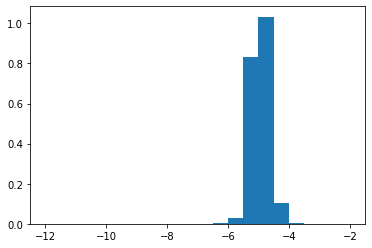

In [118]:
plt.hist(np.log(np.array(ls_list)), density = True, weights = np.array(w_list), bins = 20)

(array([1.22010357e-27, 3.56440079e-21, 2.87566220e-21, 2.17045853e-09,
        8.33505250e-04, 5.61226907e-04, 6.22810410e-02, 2.80884992e-01,
        3.06312648e-01, 5.35867197e-01, 3.05452404e-01, 3.74555989e-02,
        6.64940453e-02, 3.73328648e-01, 9.23254242e-03, 9.42382311e-03,
        1.47558964e-02, 4.33782441e-05, 1.60998829e-04, 3.77589535e-05]),
 array([ 5.00741231,  5.5066321 ,  6.0058519 ,  6.50507169,  7.00429148,
         7.50351128,  8.00273107,  8.50195086,  9.00117066,  9.50039045,
         9.99961024, 10.49883003, 10.99804983, 11.49726962, 11.99648941,
        12.49570921, 12.994929  , 13.49414879, 13.99336859, 14.49258838,
        14.99180817]),
 <BarContainer object of 20 artists>)

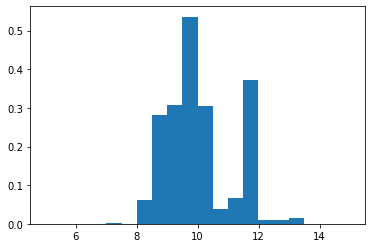

In [119]:
plt.hist(np.array(sg_list), density = True, weights = np.array(w_list), bins = 20)

(array([2.12738063e+01, 2.25665332e+00, 1.16892201e+01, 1.65874192e+01,
        6.96602556e-01, 2.57468450e+00, 1.72267415e-01, 2.50897418e+00,
        1.64525658e-03, 3.59057478e+00, 8.84707139e+00, 3.32254790e+00,
        3.57767395e+00, 3.20479904e+00, 4.45175701e+00, 2.84050640e+00,
        1.00881098e-01, 1.22909547e+01, 5.45679741e-02, 1.31698630e-02]),
 array([0.05005086, 0.06004529, 0.07003971, 0.08003414, 0.09002856,
        0.10002299, 0.11001741, 0.12001184, 0.13000627, 0.14000069,
        0.14999512, 0.15998954, 0.16998397, 0.17997839, 0.18997282,
        0.19996724, 0.20996167, 0.21995609, 0.22995052, 0.23994495,
        0.24993937]),
 <BarContainer object of 20 artists>)

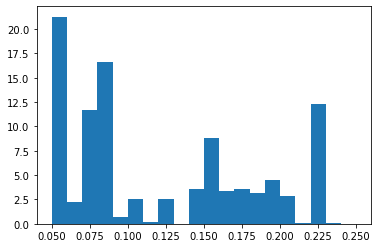

In [120]:
plt.hist(np.array(br_list), density = True, weights = np.array(w_list), bins = 20)

In [121]:
post_mean_params = { "base_rate" : np.dot(w_list,br_list)/np.sum(w_list),
                       "lengthscale" : np.exp(np.dot(w_list,np.log(ls_list))/np.sum(w_list)),
                       "gp_sigma" : np.dot(w_list,sg_list)/np.sum(w_list),
                       "gp_ridge" : .01,
            "gp_offset": marg_probs-10.0
            }
post_mean_params

{'base_rate': 0.12047794274665982,
 'lengthscale': 0.006908313476433971,
 'gp_sigma': 10.07912531094126,
 'gp_ridge': 0.01,
 'gp_offset': array([-10.72533214, -10.72533214, -11.315303  , -10.72533214,
        -10.26646592, -11.05309373, -11.18419837, -11.11864605,
        -11.05309373, -11.18419837, -10.92198909, -11.05309373,
         -9.54539042, -10.39757055, -10.85643678, -11.11864605,
        -11.05309373, -11.11864605, -11.44640764, -11.44640764,
        -11.51195996, -10.85643678, -11.24975068, -10.85643678,
        -11.51195996, -11.315303  , -11.44640764, -11.38085532,
        -11.11864605, -11.38085532, -11.315303  , -11.315303  ,
         -9.80759969, -11.24975068, -11.315303  ,  -9.15207651,
        -10.46312287, -11.18419837, -10.92198909, -11.44640764,
        -11.18419837, -11.38085532, -11.315303  , -11.11864605,
        -10.92198909,  -9.08652419,  -8.29989638, -11.315303  ,
        -11.18419837, -10.33201823, -10.46312287,  -9.74204737,
        -10.52867519, -10.59422

In [122]:
sample,A, A_t, g = gen_batch(germline, post_mean_params, 20000, True)
sample_bp = (1.0-np.mean(sample == germline, axis = 0))
sample_colocal = get_colocal(sample,germline, sample_bp,50)

<ipython-input-15-d02188c868cd>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mut), np.array(les), np.array(preles), np.array(gaus)
<ipython-input-116-b676d266d21b>:9: RuntimeWarning: invalid value encountered in double_scalars
  values[i] = p_1/(p_2*p_3)
<ipython-input-116-b676d266d21b>:10: RuntimeWarning: divide by zero encountered in double_scalars
  vars[i] = (1-p_2-p_3+p_2*p_3)/(len(seqs)*p_2*p_3)


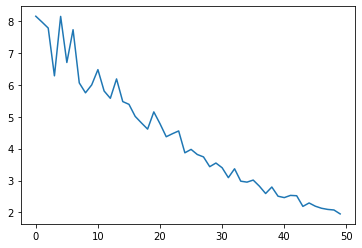

In [123]:
plt.plot(sample_colocal)

In [124]:
colocals = get_colocal(seqs,germline,base_prob,50)

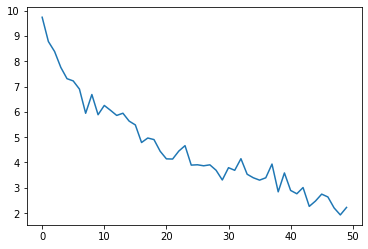

In [125]:
plt.plot(colocals)

In [28]:
colocal_list = []

In [29]:
for i in range(500):
    boot_sample = np.array([random.choice(seqs) for _ in seqs])
    probs, deno, base_prob, sample = get_real_colocal(boot_sample)
    colocal_list.append(probs/deno)

In [30]:
probs,deno, base_prob, sample = get_real_colocal(seqs)
y = probs/deno

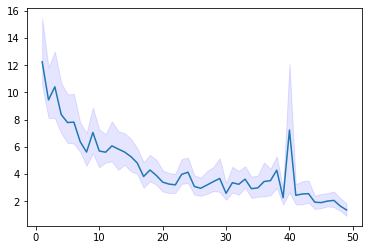

In [31]:
#some example data
x= np.linspace(1,49,49)
low = np.quantile(colocal_list, 0.05, axis = 0)
high = np.quantile(colocal_list, 0.95, axis = 0)

fig, ax = plt.subplots()
ax.plot(x,y)
ax.fill_between(x, low, high, color='b', alpha=.1)

In [32]:
np.linspace(1,50,50)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

In [33]:
probs, deno, base_prob, sample = get_colocal(2000, post_mean_params, sample = None, re = True)

<ipython-input-15-d02188c868cd>:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mut), np.array(les), np.array(preles), np.array(gaus)


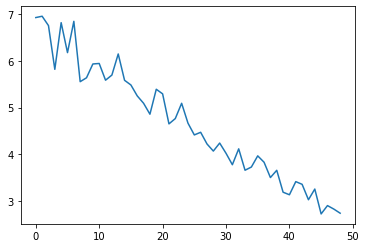

In [34]:
plt.plot(probs/deno)

In [35]:
probs,deno, base_prob, sample = get_real_colocal(seqs)

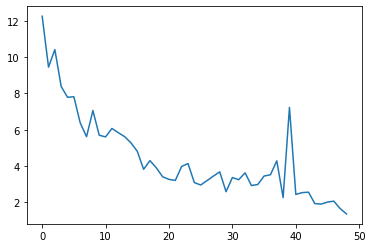

In [36]:
plt.plot(probs/deno)